In [931]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve

In [932]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=15):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [933]:
s  = ctl.TransferFunction.s
G  =  0.0206708134012297*(0.155605773*s**2 - 0.400634718*s + 1.0)/(0.15560577*s**2 - 0.78893795*s + 1.0)
#G = 12/((s-10)*(s+5))

G_bpk = G
G

TransferFunction(array([ 0.0032165 , -0.00828145,  0.02067081]), array([ 0.15560577, -0.78893795,  1.        ]))

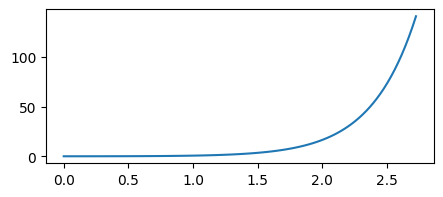

In [934]:
time, response = ctl.step_response(G)
plt.figure(figsize=(5, 2))
plt.plot(time, response)

- Encontrando as características da resposta transitória e permanente

In [935]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  140.71111244248542
tempo de pico:  2.7252219003059777
tempo de assentamento:  None
valor final:  140.71111244248542
erro:  139.71111244248542


- Encontrando os polos do sistema

In [936]:
polos = ctl.pole(G)
zeros = ctl.zeros(G)

print(polos)
print(zeros)

[2.53535764+0.j 2.53474966+0.j]
[1.28733886+2.1838625j 1.28733886-2.1838625j]


# ENCONTRANDO OS PARÂMETROS DESEJADOS
- O primeiro parâmetero é que o erro seja nulo, ou seja $c(\infty) = \lim_{t \to \infty} c(t) = \lim_{s \to 0} s\,C(s) = \lim_{s \to 0} s\,G(s)R(s)= 0$

- O segundo parâmetro se refere à resposta transitória do sistema, ou seja, queremos alguma informação da resposta transitória que nos dê $\zeta$. Um bom parâmetro é o tempo de estabilização $T_s$, gostaria que $T_s$ fosse pequeno.

$T_s = \frac{4}{\zeta\omega_n}$


In [937]:
Ts = 5
UP = 0.9

In [938]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.03351844910567637

In [939]:
Wn = 4/(zeta*Ts)
Wn

23.867452741556576

###  ROOT LOCUS
Uma maneira de encontrar o polo desejado $s_D$ para o controlador é encontrando a interseção da linha vertical projetada por $\zeta$ com o caminho percorrido pelo LGR. O root locus nos dá uma informação importante sobre como é possível controlar o sistema, mostrando o caminho pelo qual os polos e zeros podem percorrer para chegar em uma estabilidade, ou seja, no semiplano esquerdo

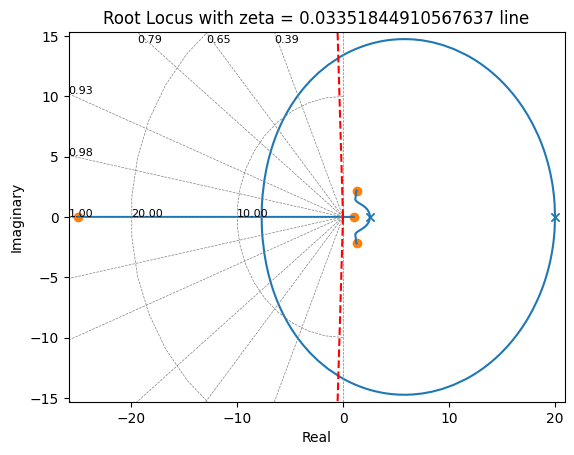

ZeroDivisionError: division by zero

In [947]:
def zGrid(G, zeta):
    ctl.root_locus(G)

    angle  = np.arccos(zeta)
    radius = np.linspace(0, 100, 400)

    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    
    plt.plot(-x, y, 'r--')
    plt.plot(-x, -y, 'r--')

    plt.title(f'Root Locus with zeta = {zeta} line')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show()


C_test = (s+25)*(s-1)/((s-20)*(s-20))
zGrid(G*C_test, zeta)
1/0

In [ ]:
G = G*(s-25)/((s-20)*(s-20))
G_bkp = G

- Pode se observar que a linha azul vai até o semiplano esquerdo, então é possível mover o polo instável por essa linha até estabilizar o sistema, esse é o objetivo do controlador
- Uma outra forma é usar a relação: $s = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta^2}j$

In [ ]:
s_desired = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_desired

-0.8 + 23.8540415940452*I

# IMPLEMENTANDO O CONTROLADOR PID
- Encontrando as constantes do controlador: $C(s) = K\frac{(s-a)(s-b)}{s(s+p)}$

- $p$ é um polo colocado arbitrariamente pois o número de polos tem que ser maior ou igual o número de zeros, para que seja possível implementá-lo digitalmente, com uma função de transferência própria. Esse polo $p$ precisa estar longe do eixo imaginário para que tenha pouca influência no sistema

In [ ]:
s = sp.symbols('s')
K, a, b = sp.symbols('K a b', real=True)

G = sympyFunction(G)
G

(0.00321649789783711*s**3 - 0.0243639349870178*s**2 + 0.0620780408903911*s - 0.103354067006148)/(0.15560577*s**4 - 7.01316875*s**3 + 94.799826*s**2 - 355.57518*s + 400.0)

- A função de transferência final em malha aberta será $G(s)C(s)$

In [ ]:
C     = K * ((s + a) * (s + b)) / (s * (s + 20))
C_bkp = str(C)

C

K*(a + s)*(b + s)/(s*(s + 20))

In [ ]:
GC = G * C
GC

K*(a + s)*(b + s)*(0.00321649789783711*s**3 - 0.0243639349870178*s**2 + 0.0620780408903911*s - 0.103354067006148)/(s*(s + 20)*(0.15560577*s**4 - 7.01316875*s**3 + 94.799826*s**2 - 355.57518*s + 400.0))

In [ ]:
ZERO = 1e-10

- Erro em regime permanente para entrada em degrau é igual a zero (malha fechada)

- $erro = \frac{1}{1+K_p}$ onde $K_p = \lim_{s\to 0} G(s)$

In [ ]:
Kp  = GC.subs(s, ZERO).expand().simplify()
eq1 = 1/(1 + Kp)
eq1 = sp.Eq(eq1, ZERO)
eq1

Eq(1/(K*(-129192.583760764*a*b - 1.29192583760764e-5*a - 1.29192583760764e-5*b - 1.29192583760764e-15) + 1), 1.0e-10)

- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [ ]:
G_aux = GC.subs(s, s_desired)
angle = sp.arg(G_aux)

eq2 = sp.Eq(angle + sp.pi, ZERO)
eq2

Eq(arg(-K*(0.8 + 23.8540415940452*I)*(19.2 - 23.8540415940452*I)*(a - 0.8 + 23.8540415940452*I)*(b - 0.8 + 23.8540415940452*I)*(-0.153016499718461 + 0.00321649789783711*(-0.8 + 23.8540415940452*I)**3 - 0.0243639349870178*(-0.8 + 23.8540415940452*I)**2 + 1.48081216947623*I)/(684.460144 - 8481.90513353009*I + 94.799826*(-0.8 + 23.8540415940452*I)**2 + 0.15560577*(-0.8 + 23.8540415940452*I)**4 - 7.01316875*(-0.8 + 23.8540415940452*I)**3)) + pi, 1.0e-10)

- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [ ]:
G_aux  = GC.subs(s, s_desired)
modulo = sp.Abs(G_aux).expand().simplify()
eq3    = sp.Eq(modulo - 1, ZERO)
eq3

Eq(0.779443186195822*sqrt(2016.34804231858 + 7.105427357601e-15*I)*sqrt(0.00175544754757784*a**2 - 0.00280871607612454*a + 1)*sqrt(0.00175544754757784*b**2 - 0.00280871607612454*b + 1)*Abs(K)/sqrt(8176179793.83794 + 4.17232513427734e-7*I) - 1, 1.0e-10)

In [ ]:
def convertString(eq):
    return str(eq.lhs).replace('sqrt', 'np.sqrt').replace('Abs', 'np.abs').replace('pi', 'np.pi').replace('arg', 'np.angle').replace('*I', 'j').replace('I)', '1j)')

str_eq1 = convertString(eq1)
str_eq2 = convertString(eq2)
str_eq3 = convertString(eq3)

print(str_eq1)
print(str_eq2)
print(str_eq3)

1/(K*(-129192.583760764*a*b - 1.29192583760764e-5*a - 1.29192583760764e-5*b - 1.29192583760764e-15) + 1)
np.angle(-K*(0.8 + 23.8540415940452j)*(19.2 - 23.8540415940452j)*(a - 0.8 + 23.8540415940452j)*(b - 0.8 + 23.8540415940452j)*(-0.153016499718461 + 0.00321649789783711*(-0.8 + 23.8540415940452j)**3 - 0.0243639349870178*(-0.8 + 23.8540415940452j)**2 + 1.48081216947623j)/(684.460144 - 8481.90513353009j + 94.799826*(-0.8 + 23.8540415940452j)**2 + 0.15560577*(-0.8 + 23.8540415940452j)**4 - 7.01316875*(-0.8 + 23.8540415940452j)**3)) + np.pi
0.779443186195822*np.sqrt(2016.34804231858 + 7.105427357601e-15j)*np.sqrt(0.00175544754757784*a**2 - 0.00280871607612454*a + 1)*np.sqrt(0.00175544754757784*b**2 - 0.00280871607612454*b + 1)*np.abs(K)/np.sqrt(8176179793.83794 + 4.17232513427734e-7j) - 1


In [ ]:
def sistema(variaveis):
    (K, a, b) = variaveis
    return [
        eval(str_eq1), 
        eval(str_eq2),
        eval(str_eq3)
    ]

solutions = fsolve(sistema, [1, 1, 1], maxfev=100000, xtol=ZERO)
print('Solucoes:', solutions, '\n')

Solucoes: [921.00989257  -6.17423213  61.43435715] 



/home/klauss/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
/home/klauss/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
for eq in [eq1, eq2, eq3]:
    sol = eq.lhs.subs({
        K: solutions[0],
        a: solutions[1],
        b: solutions[2]
    })
    print(sp.re(sol))

2.21566373450064e-11
0.00594285526513612
-1 + 2040.68593293254*re(sqrt(2016.34804231858 + 7.105427357601e-15*I)/sqrt(8176179793.83794 + 4.17232513427734e-7*I))


In [ ]:
K = solutions[0]
a = solutions[1]
b = solutions[2]

- Função de transferência do controlador $C(s)$

In [ ]:
s = ctl.TransferFunction.s
C = eval(C_bkp)

print(sympyFunction(C))
C

(921.009892571017*s**2 + 50895.121809794*s - 349348.245737751)/(s**2 + 20*s)


TransferFunction(array([    921.00989257,   50895.12180979, -349348.24573775]), array([ 1, 20,  0]))

- Função de transferência do sistema em malha aberta $C(s)G(s)$

In [ ]:
G  = G_bpk

GC = G*C
GC

TransferFunction(array([ 2.96242638e+00,  1.56076759e+02, -1.52612505e+03,  3.94515202e+03,
       -7.22131240e+03]), array([  0.15560577,   2.32317745, -14.778759  ,  20.        ,
         0.        ]))

- Função de transferência em malha fechada com realimentação unitária $G_{feedback}(s) = \frac{G(s)C(s)}{1+G(s)C(s)}$

In [ ]:
G_feedback = ctl.feedback(GC, 1)
G_feedback

TransferFunction(array([ 2.96242638e+00,  1.56076759e+02, -1.52612505e+03,  3.94515202e+03,
       -7.22131240e+03]), array([ 3.11803215e+00,  1.58399937e+02, -1.54090381e+03,  3.96515202e+03,
       -7.22131240e+03]))

In [ ]:
ctl.poles(G_feedback)

array([-59.48020186+0.j        ,   6.11749044+0.j        ,
         1.28072981+2.17361569j,   1.28072981-2.17361569j])

# APLICANDO UM STEP

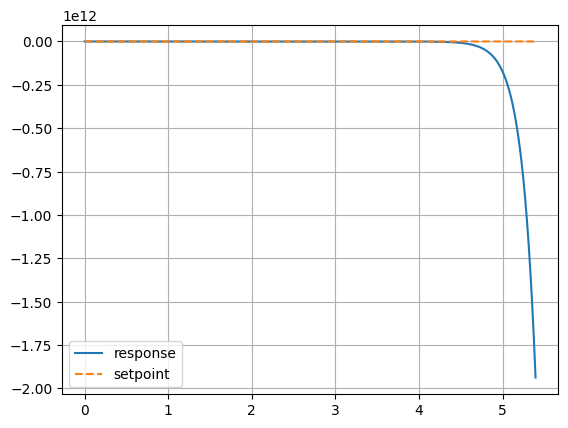

In [ ]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, label='response')
plt.plot(time, [1 for i in time], '--', label='setpoint')
plt.legend()
plt.grid()

In [ ]:
getAllInfo(time, response, setpoint=1)

overshoot:  inf
valor de pico:  0.9758938050069851
tempo de pico:  0.05108023615210311
tempo de assentamento:  None
valor final:  -1937516112369.5862
erro:  1937516112368.5862


# APLICANDO VÁRIOS STEPS

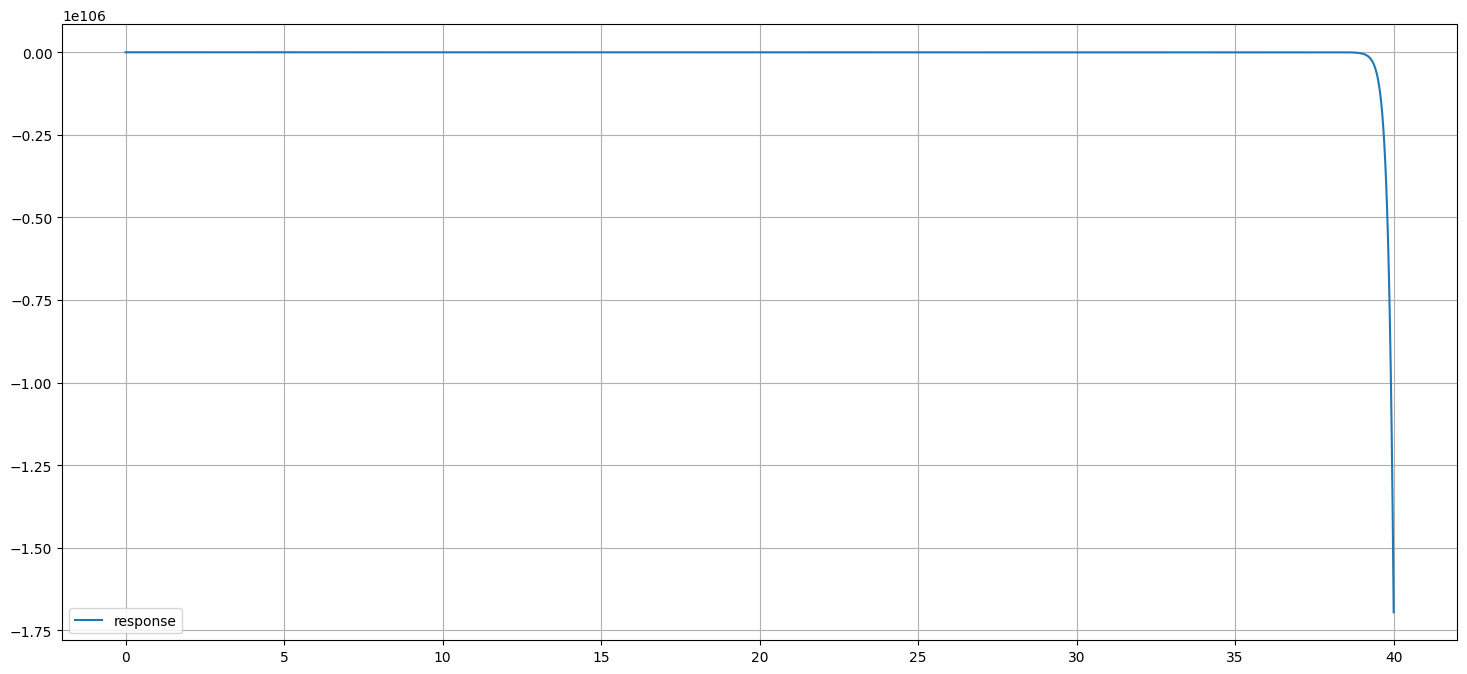

In [ ]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()